Notebook for generating training and test data for the laminar (no temporal dimension) and the time periodic (with temporal dimension) navier stokes problems 
without any domain decomposition (could add to same notebook later idk)

In [1]:
from region_utils.shapes import Circle, ConvexPolygon
from region_utils.region import Domain, Subdomain
import jax.numpy as np
import numpy as onp
import json


#### Domain with matching dimensionality of problem in [DFG flow around cylinder benchmark 2D-1](https://wwwold.mathematik.tu-dortmund.de/~featflow/en/benchmarks/cfdbenchmarking/flow/dfg_benchmark1_re20.html) 

$$\omega =[0,2.2]×[0,0.41]∖B_r(0.2,0.2)$$
$$r = 0.05$$

In [2]:
#vertecies of domain in counter clockwise order
v1 = [0,0]
v2 = [2.2,0]
v3 = [2.2, 0.41]
v4 = [0, 0.41]

domain_points = np.asarray([v1, v2, v3, v4])
Cylinder = Circle(center=np.array([0.2, 0.2]), radius=0.05, has_boundary=True)
OuterRectangle = ConvexPolygon(domain_points, list(range(4)))

In [3]:
subdomain0 = Subdomain([OuterRectangle], [Cylinder])
domain = Domain([subdomain0])

In [4]:
domain.create_boundary(100)
domain.create_interior(500, [0, 0], [2.2, 0.41])

(495, 2)


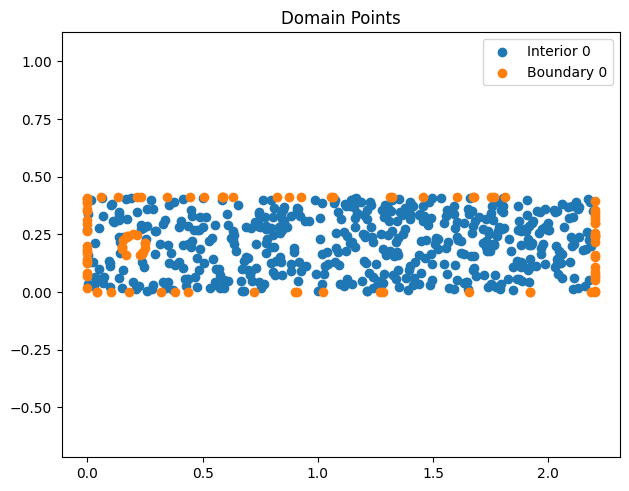

In [5]:
import matplotlib.pyplot as plt

plt.axis("equal")
# tight layout
plt.tight_layout()

domain.plot()

In [6]:
from utils import data_path

data_path = data_path / "NavierStokes"

domain.write_to_file(data_path / "single_pinn_train.json")

Func for adding temporal dimension

In [7]:
def add_temporal_dimension_training_data(input_file, t_max = 10, overwrite=False):
    str_rep = str(input_file)
    wo_suff = str_rep.removesuffix(".json")
    if overwrite:
        outfile = input_file
    else: 
        outfile = f"{wo_suff}_w_temporal.json"
    with open(input_file, "r") as infile:
        data = json.load(infile)
        for p in data['XPINNs']:
            for point in p['Internal points']:
                point.append(float(onp.random.uniform(0, t_max)))
            for point in p['Boundary points']:
                point.append(float(onp.random.uniform(0, t_max)))       
        for s in data['Interfaces']:
            for point in s['Points']:
                point.append(float(onp.random.uniform(0, t_max)))
                
    with open(outfile, "w") as outfile:
        json.dump(data, outfile)

In [9]:
file = data_path / "single_pinn_train.json"
add_temporal_dimension_training_data(file, overwrite=False)

Let's attempt to sort the different boundaries

In [11]:
def sort_boundaries(input_file, overwrite=False):
    """Sorts the boundary points in the json file and adds the 
        indices of the different boundaries to the dictionary.
        We have three different boundaries, left, wall and right.

    Args:
        input_file (Path): The path to the json file.
        overwrite (bool, optional): Overwrites if true. Defaults to False.
    """
    str_rep = str(input_file)
    wo_suff = str_rep.removesuffix(".json")
    if overwrite:
        outfile = input_file
    else:
        outfile = f"{wo_suff}_sorted.json"
    with open(input_file, "r") as infile:
        data = json.load(infile)
        #create buckets for the different boundaries
        left_boundary = []
        wall_boundary = []
        right_boundary = []
        for p in data['XPINNs']:
            for point in p['Boundary points']:
                if np.isclose(point[0],0):
                    left_boundary.append(point)    
                if np.isclose(point[0], 2.2):
                    right_boundary.append(point)
                else:
                    wall_boundary.append(point)
                    
            #now we combine the buckets and note the indecies of the different boundaries
            all_boundaries = left_boundary + wall_boundary + right_boundary
            left_boundary_index = len(left_boundary)
            wall_boundary_index = left_boundary_index + len(wall_boundary)
            right_boundary_index = wall_boundary_index + len(right_boundary)
    
           
            p['Boundary points'] = all_boundaries
            p['left boundary'] = left_boundary
            p['wall boundary'] = wall_boundary
            p['right boundary'] = right_boundary
            p['Boundary indices'] = [left_boundary_index, wall_boundary_index, right_boundary_index]
            
    
    with open(outfile, "w") as outfile:
        json.dump(data, outfile)

In [12]:
file1 = data_path / "single_pinn_train.json"
file2 = data_path / "single_pinn_train_w_temporal.json"
sort_boundaries(file1, overwrite=True)
sort_boundaries(file2, overwrite=True)

#### Test data

We would like to animate our solution so we generate random points in the xy plane, duplicate them and add a temporal dimention. (Not sure what resolution is sufficient)

In [13]:
domain.create_testing_data(100, v1, v3)
domain.write_to_file(data_path / "test.json", False)

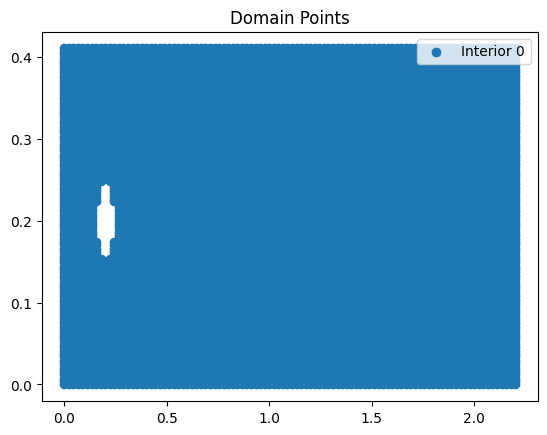

In [14]:
domain.plot(False)

In [15]:
def add_temporal_dimension_test_data(input_file, n:int = 2, t_max = 10, overwrite=False):
    """Adds temporal dimention to data

    Args:
        input_file (str): .json file with data w/o temporal dimension
        n (int, optional): temporal resolution. Defaults to 100.
        overwrite (bool, optional): overwrites infile if true. Defaults to False.
    """
    t = np.linspace(0, t_max, n)
    str_rep = str(input_file)
    wo_suff = str_rep.removesuffix(".json")
    if overwrite:
        outfile = input_file
    else:
        outfile = f"{wo_suff}_w_temporal.json"
    with open(input_file, "r") as infile:
        data = json.load(infile)
        for p in data['XPINNs']:
            m = len(p['Internal points'])
            k = len(p['Boundary points'])
            p['Internal points'] = n*p['Internal points']
            p['Boundary points'] = n*p['Boundary points']
            for i in range(n-1):
                for point in p['Internal points'][i*m:m*(i+1)]:
                    point.append(float(t[i]))
                for point in p['Boundary points'][i*k:k*(i+1)]:
                    point.append(float(t[i]))
    with open(outfile, "w") as outfile:
        json.dump(data, outfile)

In [17]:
add_temporal_dimension_test_data(data_path / "test.json", n=10, t_max=3, overwrite=False)